# Лабораторная работа 2.7: Распознавание рукописных цифр MNIST

## Формулировка задачи

Обучить нейронную сеть для классификации рукописных цифр из датасета MNIST (28×28 пикселей, 10 классов: цифры 0-9).

## Архитектура сети

**Структура:** Входной слой (784) → Скрытый слой (128) → Выходной слой (10)

- **Входной слой:** 784 нейрона (28×28 пикселей, преобразованных в вектор)
- **Скрытый слой:** 128 нейронов с активацией sigmoid
- **Выходной слой:** 10 нейронов (цифры 0-9) с активацией softmax

**Общее количество параметров:** 101,770 (W1: 100,352, b1: 128, W2: 1,280, b2: 10)

## Функции активации

### Sigmoid (скрытый слой)
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
Преобразует значения в диапазон (0, 1), добавляет нелинейность.

### Softmax (выходной слой)
$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{10} e^{z_j}}$$
Преобразует выходы в вероятностное распределение (сумма = 1.0).

## Процесс обучения

**Гиперпараметры:**
- epochs = 15
- batch_size = 128
- learning_rate = 0.1

**Алгоритм:**
1. **Прямое распространение (Forward):** вычисление предсказаний через сеть
2. **Обратное распространение (Backward):** вычисление градиентов функции потерь
3. **Обновление весов:** градиентный спуск с заданной скоростью обучения

**Особенности:**
- Нормализация данных: пиксели из [0, 255] в [0.0, 1.0]
- One-hot encoding меток для обучения
- Перемешивание данных перед каждой эпохой
- Обучение мини-батчами для эффективности

## Результаты

После 15 эпох обучения достигается точность ~93-94% на тестовой выборке, что подтверждает способность сети обобщать на новые данные.


In [1]:
# 2.7 MNIST
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pandas as pd


In [2]:
#Чтение данных
def load_mnist(path, kind='train'):
    labels_path = f'{path}/{kind}-labels-idx1-ubyte.gz'
    images_path = f'{path}/{kind}-images-idx3-ubyte.gz'
    
    with gzip.open(labels_path, 'rb') as f:
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    
    with gzip.open(images_path, 'rb') as f:
        images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
    
    return images, labels

X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

# Нормализация
X_train = X_train / 255
X_test = X_test / 255

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (60000, 784), Test: (10000, 784)


In [3]:
# Категоризация
def one_hot(y, n_classes=10):
    result = np.zeros((y.size, n_classes))
    result[np.arange(y.size), y] = 1
    return result

y_train_hot = one_hot(y_train)
y_test_hot = one_hot(y_test)


In [4]:
# Функции активации
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


In [5]:
# Нейронная сеть
class NN:
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = softmax(self.z2)
        return self.a2
    
    def backward(self, X, y, lr=0.1):
        m = X.shape[0]
        
        dz2 = self.a2 - y
        dW2 = (1/m) * np.dot(self.a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.a1 * (1 - self.a1)
        dW1 = (1/m) * np.dot(X.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


In [6]:
# Обучение
nn = NN()
epochs = 15
batch_size = 128
lr = 0.1

train_acc = []
test_acc = []

for epoch in range(epochs):
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train_hot[indices]
    
    for i in range(0, len(X_train), batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        nn.forward(X_batch)
        nn.backward(X_batch, y_batch, lr)
    
    train_pred = nn.predict(X_train)
    test_pred = nn.predict(X_test)
    
    train_accuracy = np.mean(train_pred == y_train) * 100
    test_accuracy = np.mean(test_pred == y_test) * 100
    
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
    
    if True:
        print(f"Epoch {epoch+1}/{epochs}: Train={train_accuracy:.2f}%, Test={test_accuracy:.2f}%")

print(f"\nFinal: Train={train_acc[-1]:.2f}%, Test={test_acc[-1]:.2f}%")


Epoch 1/15: Train=78.45%, Test=79.08%
Epoch 2/15: Train=86.81%, Test=87.14%
Epoch 3/15: Train=89.12%, Test=89.72%
Epoch 4/15: Train=90.10%, Test=90.45%
Epoch 5/15: Train=90.79%, Test=91.19%
Epoch 6/15: Train=91.23%, Test=91.53%
Epoch 7/15: Train=91.53%, Test=91.82%
Epoch 8/15: Train=91.88%, Test=92.27%
Epoch 9/15: Train=92.15%, Test=92.51%
Epoch 10/15: Train=92.34%, Test=92.63%
Epoch 11/15: Train=92.78%, Test=92.81%
Epoch 12/15: Train=92.91%, Test=93.05%
Epoch 13/15: Train=93.21%, Test=93.30%
Epoch 14/15: Train=93.39%, Test=93.40%
Epoch 15/15: Train=93.58%, Test=93.69%

Final: Train=93.58%, Test=93.69%


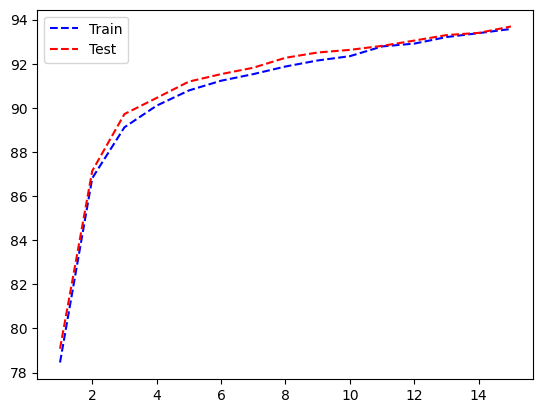

,Epoch,Train,Test,Diff
0,1,78.455000,79.08,-0.625000
1,2,86.810000,87.14,-0.330000
2,3,89.118333,89.72,-0.601667
3,4,90.100000,90.45,-0.350000
4,5,90.788333,91.19,-0.401667
5,6,91.230000,91.53,-0.300000
6,7,91.530000,91.82,-0.290000
7,8,91.875000,92.27,-0.395000
8,9,92.148333,92.51,-0.361667
9,10,92.343333,92.63,-0.286667


In [7]:
# График обучения
plt.plot(range(1, epochs+1), train_acc, 'b--', label='Train')
plt.plot(range(1, epochs+1), test_acc, 'r--', label='Test')
plt.legend()
plt.show()

results = []
epochs_list = list(range(1, 16))

for e in epochs_list:
    results.append({
        'Epoch': e,
        'Train': train_acc[e-1],
        'Test': test_acc[e-1],
        'Diff': train_acc[e-1] - test_acc[e-1]
    })

df = pd.DataFrame(results)
display(df)



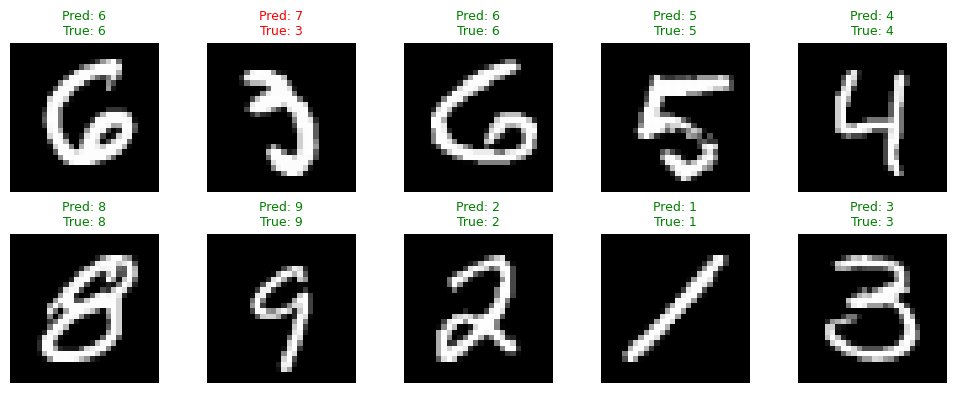

In [8]:
# Примеры распознавания
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(len(X_test))
    image = X_test[idx].reshape(28, 28)
    pred = test_pred[idx]
    true = y_test[idx]
    
    ax.imshow(image, cmap='gray')
    color = 'green' if pred == true else 'red'
    ax.set_title(f"Pred: {pred}\nTrue: {true}", color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()
